In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import PIL
import PIL.Image

/Users/boubalkaly/Desktop/brain-tumor/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#load the training and testing datasets
training_dir = './cleaned/Training'
testing_dir = './cleaned/Testing'
training_set = tf.keras.utils.image_dataset_from_directory(training_dir)
testing_set = tf.keras.utils.image_dataset_from_directory(testing_dir)

class_names = training_set.class_names
print(class_names)


    

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


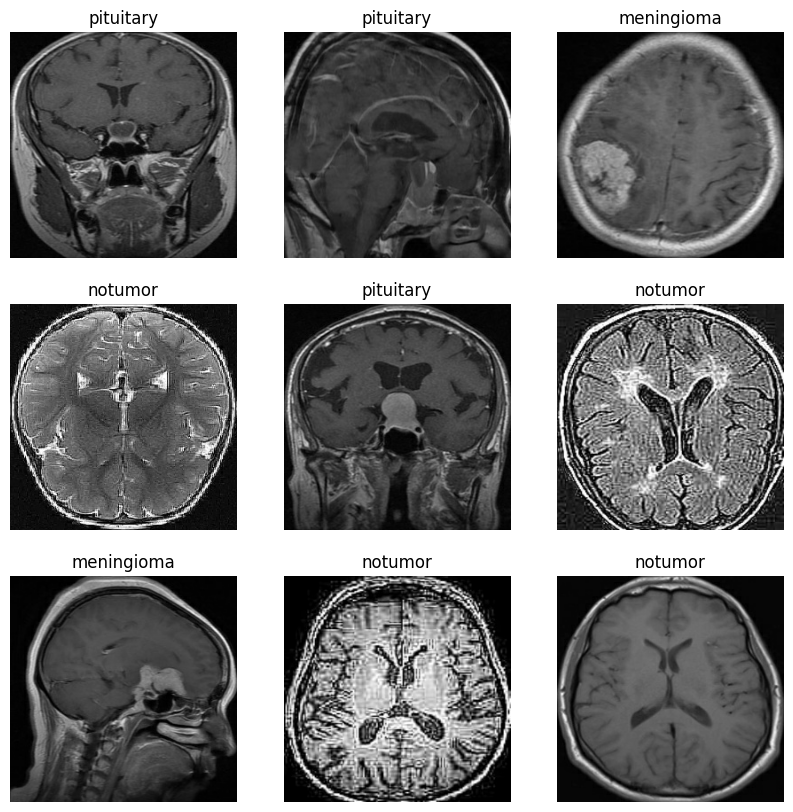

In [4]:
#now we are doing to do some data visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')



        
    
    

In [5]:
#now we are going to standardize the data in order to make it more compatible for a neural network
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
normalized_testing_set = testing_set.map(lambda x, y: (normalization_layer(x), y))

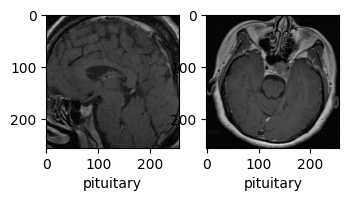

In [6]:
training_images, training_labels = zip(*normalized_training_set)
testing_images, testing_labels = zip(*normalized_testing_set)
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(5, 5, i + 1)
    plt.grid = False
    plt.imshow(training_images[i][0])
    plt.xlabel(class_names[training_labels[i][0]])
plt.show()
training_images = np.concatenate(training_images)
training_labels = np.concatenate(training_labels)
testing_images = np.concatenate(testing_images)
testing_labels = np.concatenate(testing_labels)


In [7]:
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(5712, 256, 256, 3)
(5712,)
(1311, 256, 256, 3)
(1311,)


In [8]:
#adding layers to our sequential model
from tensorflow.keras import models, layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 56320 

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(class_names)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(training_images, training_labels, epochs=10, 
                    validation_data=(testing_images, testing_labels))

Epoch 1/10
179/179 [==============================] - 73s 401ms/step - loss: 1.0098 - accuracy: 0.6131 - val_loss: 0.6488 - val_accuracy: 0.7483
Epoch 2/10
179/179 [==============================] - 73s 406ms/step - loss: 0.4993 - accuracy: 0.8158 - val_loss: 0.4400 - val_accuracy: 0.8375
Epoch 3/10
179/179 [==============================] - 73s 407ms/step - loss: 0.3104 - accuracy: 0.8930 - val_loss: 0.5053 - val_accuracy: 0.8185
Epoch 4/10
179/179 [==============================] - 72s 403ms/step - loss: 0.1732 - accuracy: 0.9389 - val_loss: 0.3960 - val_accuracy: 0.8627
Epoch 5/10
179/179 [==============================] - 71s 398ms/step - loss: 0.0760 - accuracy: 0.9753 - val_loss: 0.3945 - val_accuracy: 0.8932
Epoch 6/10
179/179 [==============================] - 72s 401ms/step - loss: 0.0346 - accuracy: 0.9898 - val_loss: 0.4819 - val_accuracy: 0.8947
Epoch 7/10
179/179 [==============================] - 74s 411ms/step - loss: 0.0268 - accuracy: 0.9912 - val_loss: 0.5021 - val_ac

41/41 - 5s - loss: 0.4337 - accuracy: 0.8963 - 5s/epoch - 117ms/step


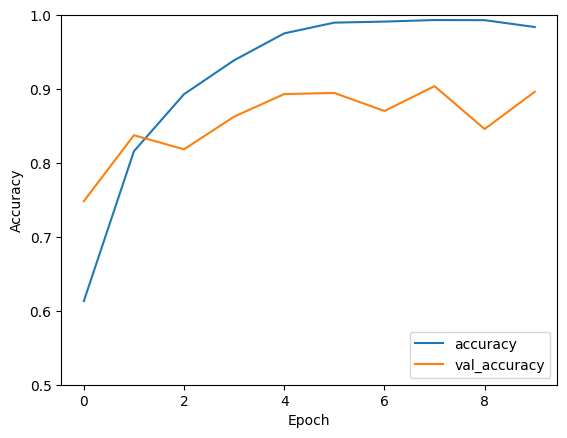

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testing_images,  testing_labels, verbose=2)

In [12]:
print(f"The accuracy of the model is "")

0.8962624073028564
